In [1]:
from matplotlib import pyplot
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
def load_dataset(batch_size):
    #define transform : iamge to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    
    #download 
    trainset = FashionMNIST(
        root = './dl_data/',
        train = True,
        download = True,
        transform = transform
    )
    
    testset = FashionMNIST(
        root = './dl_data/',
        train = False,
        download = True,
        transform = transform
    )
    
    #create loader
    
    train_loader = data.DataLoader(
        dataset = trainset,
        shuffle = True,
        batch_size = batch_size
    )
    
    test_loader = data.DataLoader(
        dataset = testset,
        batch_size = batch_size
    )
    
    return train_loader, test_loader

class Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_category)
        self.softmax = nn.Softmax(dim=1)
        self.test = True
    
    def forward(self,x):
        x = x.reshape(-1,input_size)
        out = self.softmax(self.linear(x))
        return out
    
    def train_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = loss_fn(out,labels)
        return loss
        
    def train_loss(self,losses):
        epoch_loss = torch.stack(losses).mean()
        return {'train_loss':epoch_loss.item()}
    
    def test_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = loss_fn(out,labels)
        acc = accuracy(out,labels)
        return {'test_loss' : loss.detach(), 'test_acc' : acc.detach()},[torch.max(torch.exp(out),1)[1],labels]
    
    def test_eval(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss':epoch_loss.item(), 'test_acc':epoch_acc.item()}
    
    def result(self,epoch,train_result,test_result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, train_result['train_loss'], test_result['test_loss'], test_result['test_acc']))
    
    
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,hidden_size)
        self.linear4 = nn.Linear(hidden_size,num_category)
        self.dropout = nn.Dropout(p=0.5)
        self.test = True
    
    def forward(self,x):
        x = self.linear1(x.reshape(-1,input_size))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)
        out = self.linear4(x)
        return out
    
    def train_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = loss_fn(out,labels)
        return loss
    
    def train_loss(self,losses):
        epoch_loss = torch.stack(losses).mean()
        return {'train_loss':epoch_loss.item()}
        
    def test_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = loss_fn(out,labels)
        acc = accuracy(out,labels)
        return {'test_loss' : loss.detach(), 'test_acc' : acc.detach()},[torch.max(torch.exp(out),1)[1],labels]
    
    def test_eval(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss':epoch_loss.item(), 'test_acc':epoch_acc.item()}        
     
    def result(self,epoch,train_result,test_result):
        print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, train_result['train_loss'], test_result['test_loss'], test_result['test_acc']))

In [4]:
#eval
def evaluate(model, test_loader):
    outputs= []
    raw_out = []
    raw_label = []
    for batch in test_loader:
        result, raw = model.test_step(batch)
        outputs.append(result)
        raw_out.extend(raw[0].detach().numpy())
        raw_label.extend(raw[1].detach().numpy())
    return model.test_eval(outputs), raw_out,raw_label

#fit
def fit(epochs, lr, model, train_loader, test_loader, optimizer,weight_decay):
    history = []
    optimizer = optimizer(model.parameters(),lr, weight_decay = weight_decay)
    for epoch in range(epochs):
        model.train()
        losses = []
        for batch in train_loader:
            loss = model.train_step(batch)
            losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_result = model.train_loss(losses)
        model.eval()
        test_result,raw_out,raw_label = evaluate(model,test_loader)
        model.result(epoch,train_result,test_result)
        history.append([train_result,test_result])
    return history,raw_out,raw_label

#accuracy
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))


In [5]:
#hyper paramter
epoch = 10
batch_size = 1024
learning_rate = 0.003
input_size = 28*28
num_category = 10
optimizer = torch.optim.Adam
loss_fn = F.cross_entropy
hidden_sizes=[64,128,256]
weight_decay=0
global hidden_size


#data load
train_loader, test_loader = load_dataset(batch_size)

#train
historys = []
preds=[]
labels=[]
for exp in range(0,4):
    if exp == 0: #logistic_regression
        model = Logistic_Regression()
        history,raw_out,raw_label = fit(epoch,learning_rate,model,train_loader,test_loader, optimizer,weight_decay)
    else: #feed_forward_net
        weight_decay=0.001 #for FNN l2 regularization
        hidden_size = hidden_sizes[exp-1] #for FNN
        model = FNN()
        history,raw_out,raw_label = fit(epoch,learning_rate,model,train_loader,test_loader, optimizer,weight_decay)
    historys.append(history)
    preds.append(raw_out)
    labels.append(raw_label)
    print('--------------------------------------------------')

Epoch [0], train_loss: 1.8661, test_loss: 1.7527, test_acc: 0.7443
Epoch [1], train_loss: 1.7262, test_loss: 1.7185, test_acc: 0.7716
Epoch [2], train_loss: 1.7024, test_loss: 1.7012, test_acc: 0.7831
Epoch [3], train_loss: 1.6900, test_loss: 1.6910, test_acc: 0.7899
Epoch [4], train_loss: 1.6690, test_loss: 1.6644, test_acc: 0.8192
Epoch [5], train_loss: 1.6506, test_loss: 1.6561, test_acc: 0.8238
Epoch [6], train_loss: 1.6424, test_loss: 1.6494, test_acc: 0.8296
Epoch [7], train_loss: 1.6369, test_loss: 1.6461, test_acc: 0.8310
Epoch [8], train_loss: 1.6332, test_loss: 1.6428, test_acc: 0.8345
Epoch [9], train_loss: 1.6295, test_loss: 1.6396, test_acc: 0.8368
--------------------------------------------------
Epoch [0], train_loss: 1.0607, test_loss: 0.6097, test_acc: 0.7809
Epoch [1], train_loss: 0.7029, test_loss: 0.5454, test_acc: 0.8125
Epoch [2], train_loss: 0.6551, test_loss: 0.5334, test_acc: 0.8119
Epoch [3], train_loss: 0.6332, test_loss: 0.5049, test_acc: 0.8221
Epoch [4], 

In [6]:
def historyF(history):
    train_loss=[]
    test_loss=[]
    for e in history:
        train_loss.append(e[0]['train_loss'])
        test_loss.append(e[1]['test_loss'])
    final_acc=history[-1][1]['test_acc']
    return train_loss,test_loss,final_acc

accuracy :  0.8367745280265808


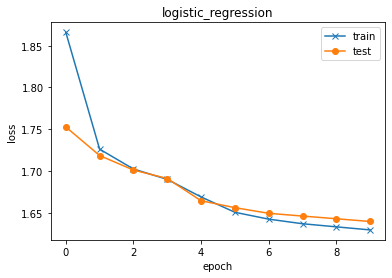

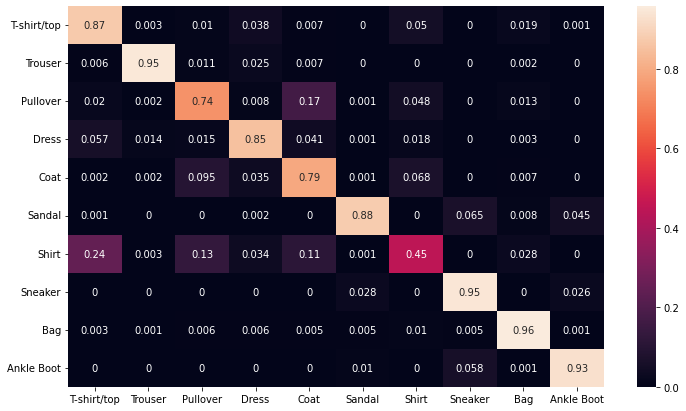

accuracy :  0.8302555084228516


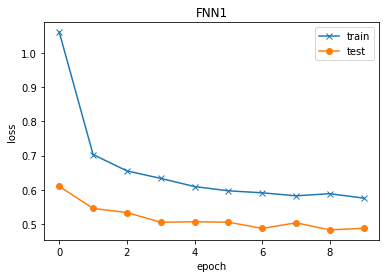

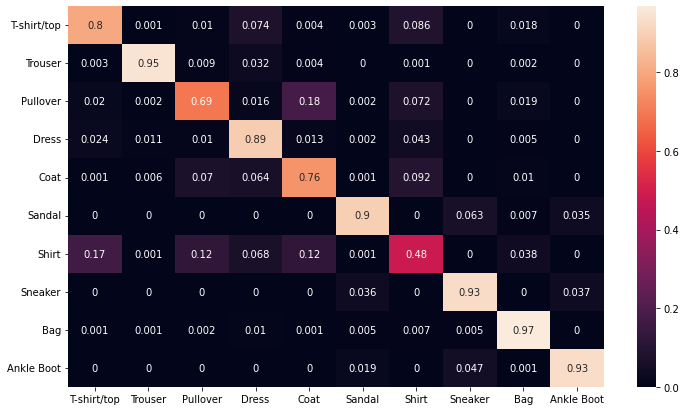

accuracy :  0.8319076299667358


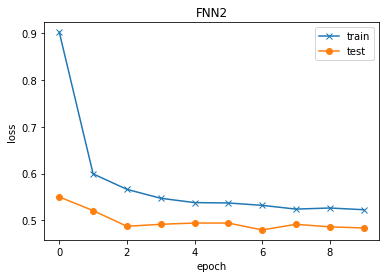

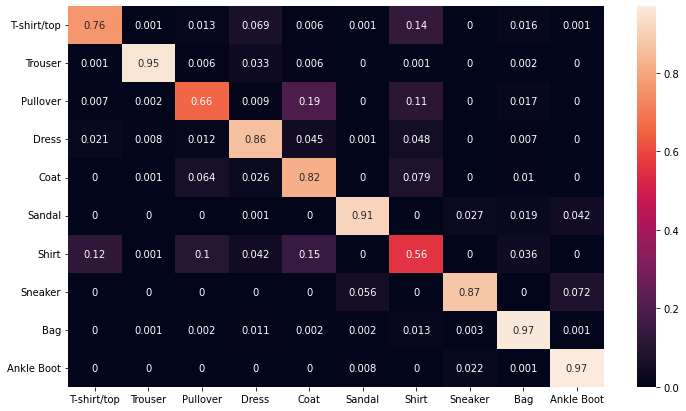

accuracy :  0.8212572336196899


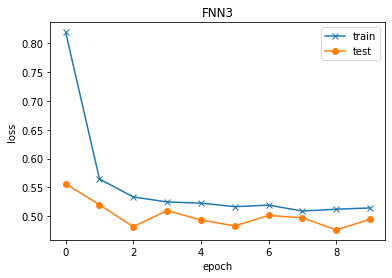

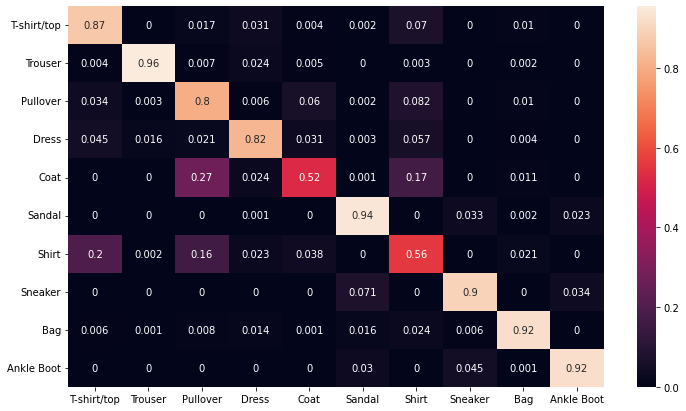

In [7]:
names = ['logistic_regression','FNN1','FNN2','FNN3']
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

for i,v in enumerate(names):
    train_loss,test_loss,test_acc = historyF(historys[i])

    plt.plot(train_loss, '-x',label='train')
    plt.plot(test_loss,'-o',label='test')
    print('accuracy : ',test_acc)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(names[i])
    plt.legend()
    plt.show()
    
    
    cf_matrix = confusion_matrix(labels[i],preds[i])
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*len(classes), index = classes, columns = classes)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm,annot=True)
    plt.show()